In [39]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
operators_5g_coverage_warsaw = gpd.read_file('../outputs/operators_5g_coverage_warsaw.geojson')

In [27]:
grouped_data = operators_5g_coverage_warsaw.groupby('operator')

In [29]:
avg_download_speed = grouped_data['avg_d_kbps'].mean() / 1024
avg_upload_speed = grouped_data['avg_u_kbps'].mean() / 1024

In [31]:
avg_latency = grouped_data['avg_lat_ms'].mean()

In [33]:
test_counts = grouped_data['tests'].sum()
device_counts = grouped_data['devices'].sum()

In [35]:
operators_5g_coverage_warsaw = operators_5g_coverage_warsaw.to_crs(epsg=3857)

operators_5g_coverage_warsaw['coverage_km2'] = operators_5g_coverage_warsaw.geometry.area / 1_000_000
coverage_area = operators_5g_coverage_warsaw.groupby('operator')['coverage_km2'].sum()

In [37]:
kpi_summary = pd.DataFrame({
    'Avg Download (Mbps)': avg_download_speed,
    'Avg Upload (Mbps)': avg_upload_speed,
    'Avg Latency (ms)': avg_latency,
    'Tests Conducted': test_counts,
    'Devices Counted': device_counts,
    'Coverage Area (km²)': coverage_area
})

display(kpi_summary)

,Avg Download (Mbps),Avg Upload (Mbps),Avg Latency (ms),Tests Conducted,Devices Counted,Coverage Area (km²)
operator,,,,,,
Orange,260.767215,34.802131,19.289931,564504,341775,13505.892240
Play,258.188294,34.491319,19.382771,1954598,1186399,47182.188954
Plus,250.937297,33.434774,19.090667,2312396,1382599,62803.389823
T-Mobile,258.704147,34.494499,19.167144,648408,394412,15944.274346


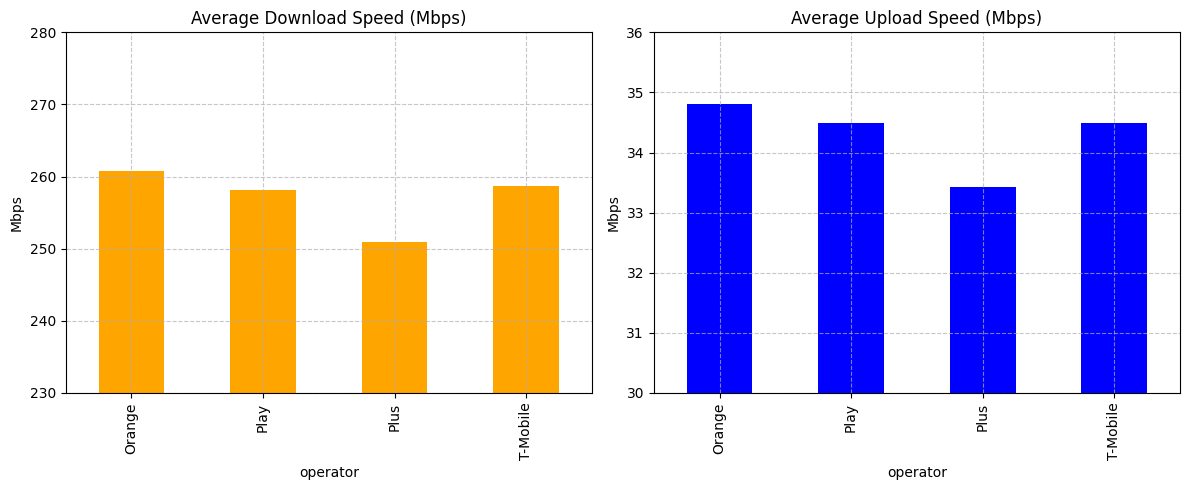

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

kpi_summary['Avg Download (Mbps)'].plot(kind='bar', color='orange', ax=ax[0])
ax[0].set_title('Average Download Speed (Mbps)')
ax[0].set_ylabel('Mbps')
ax[0].set_ylim(230, 280)
ax[0].grid(True, linestyle='--', alpha=0.7)

kpi_summary['Avg Upload (Mbps)'].plot(kind='bar', color='blue', ax=ax[1])
ax[1].set_title('Average Upload Speed (Mbps)')
ax[1].set_ylabel('Mbps')
ax[1].set_ylim(30, 36)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

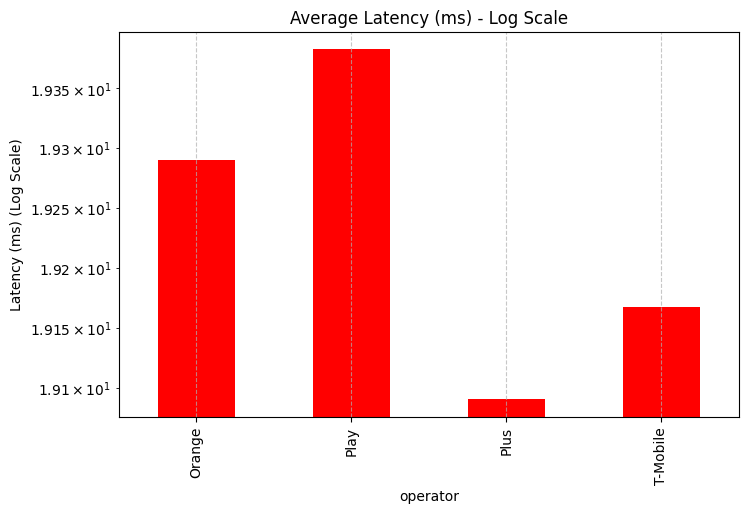

In [51]:
plt.figure(figsize=(8, 5))
kpi_summary['Avg Latency (ms)'].plot(kind='bar', color='red', logy=True)
plt.title('Average Latency (ms) - Log Scale')
plt.ylabel('Latency (ms) (Log Scale)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

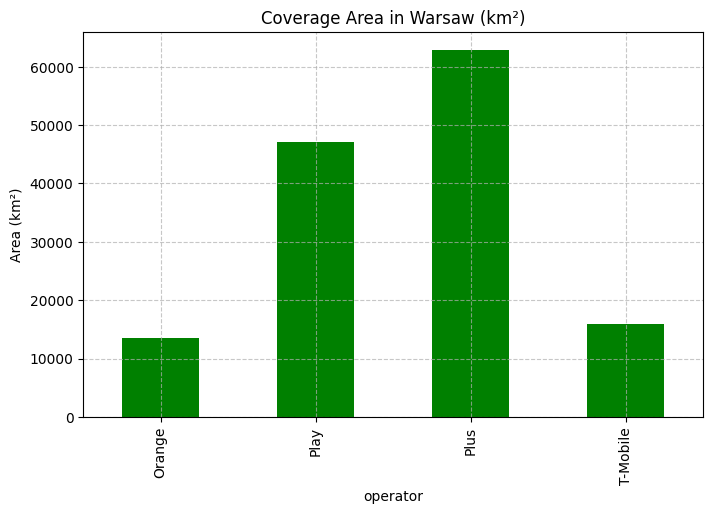

In [53]:
plt.figure(figsize=(8, 5))
kpi_summary['Coverage Area (km²)'].plot(kind='bar', color='green')
plt.title('Coverage Area in Warsaw (km²)')
plt.ylabel('Area (km²)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
##-------------------------------Percentage Coverage Analysis------------------------------##

In [65]:
grouped = operators_5g_coverage_warsaw.groupby('operator')

In [67]:
operators_5g_coverage_warsaw = operators_5g_coverage_warsaw.to_crs(epsg=3857)
operators_5g_coverage_warsaw['coverage_km2'] = operators_5g_coverage_warsaw.geometry.area / 1_000_000

In [ ]:
orange_best_area = 0
play_best_area = 0
plus_best_area = 0
tmobile_best_area = 0

for _, orange_row in operators_5g_coverage_warsaw[operators_5g_coverage_warsaw['operator'] == 'Orange'].iterrows():
    orange_speed = orange_row['avg_d_kbps']
    area = orange_row['coverage_km2']

    competitors = operators_5g_coverage_warsaw[
        (operators_5g_coverage_warsaw['cell'] == orange_row['cell']) &
        (operators_5g_coverage_warsaw['operator'] != 'Orange')
    ]

    if not competitors.empty:
        max_competitor = competitors.loc[competitors['avg_d_kbps'].idxmax()]
        if max_competitor['avg_d_kbps'] > orange_speed:
            if max_competitor['operator'] == 'Play':
                play_best_area += area
            elif max_competitor['operator'] == 'Plus':
                plus_best_area += area
            elif max_competitor['operator'] == 'T-Mobile':
                tmobile_best_area += area
        else:
            orange_best_area += area
    else:
        orange_best_area += area

In [ ]:
total_coverage = orange_best_area + play_best_area + plus_best_area + tmobile_best_area

percentage_coverage = {
    'Orange': (orange_best_area / total_coverage) * 100,
    'Play': (play_best_area / total_coverage) * 100,
    'Plus': (plus_best_area / total_coverage) * 100,
    'T-Mobile': (tmobile_best_area / total_coverage) * 100
}
coverage_df = pd.DataFrame(list(percentage_coverage.items()), columns=['Operator', 'Coverage (%)'])
display(coverage_df)

In [ ]:
coverage_df.to_csv('../outputs/5g_success_coverage_percentage.csv', index=False)
print("Coverage analysis saved to '../outputs/5g_success_coverage_percentage.csv'")